# C964 -- Music Popularity Predictor

## Setting Up Environment and Importing All Required Libraries

In [136]:
# for data manipulations
import numpy as np
import pandas as pd

# for data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for interactivity
import ipywidgets
from ipywidgets import interact

import os

small_figsize = (14, 7)
large_figsize = (18, 18)
plt.rcParams['figure.figsize'] = small_figsize

from warnings import filterwarnings as warnings

import gzip, pickle, pickletools
from sklearn.compose import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import *
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split

In [137]:
# Load the track data using pandas
track_data = pd.read_csv('../Data Sources/spotify_tracks.csv')
artist_data = pd.read_csv('../Data Sources/spotify_artists.csv')
album_data = pd.read_csv('../Data Sources/spotify_albums.csv')

In [138]:
# Exploring track data by getting a sample from the dataset
track_data.sample(2)

,Unnamed: 0,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,...,preview_url,speechiness,tempo,time_signature,track_href,track_name_prev,track_number,uri,valence,type
75146,75146,0.81800,0r7wrRVD77lNrD9t2QgZrq,https://api.spotify.com/v1/audio-analysis/0Aky...,['1kDGbuxWknIKx4FlgWxiSp'],"['AD', 'AR', 'AT', 'AU', 'BE', 'BG', 'BO', 'BR...",AR,0.672,1.0,214413.0,...,https://p.scdn.co/mp3-preview/a79dc8ace2d40276...,0.0298,127.910,4.0,https://api.spotify.com/v1/tracks/0Akytll1e5Kv...,track_36,14.0,spotify:track:0Akytll1e5KvwNKvhqIZFn,0.482,track
11263,11263,0.00722,7byXRkDthEkkmg20GRT3vm,https://api.spotify.com/v1/audio-analysis/6Nw8...,['6pr6scAuXM1recaVhecm6F'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",FI,0.790,1.0,184389.0,...,https://p.scdn.co/mp3-preview/3a36bd2341359b2b...,0.0876,134.018,4.0,https://api.spotify.com/v1/tracks/6Nw80fEKQu6X...,track_61,7.0,spotify:track:6Nw80fEKQu6XFuLYitGs7S,0.912,track


In [139]:
# Exploring artist data by getting a sample from the dataset
artist_data.sample(2)

,Unnamed: 0,artist_popularity,followers,genres,id,name,track_id,track_name_prev,type
11478,11478,26,823,[],3VS62scscMAi4sEMdcVsK1,RG,5mMHs6fbvk7KEqGF6Ht6kW,track_67,artist
9253,9253,43,5357,[],6NPAit70mG3MHreInB1pKa,Sonny Black,1UVhP6jyZp3biaZwmSerlV,track_7,artist


In [140]:
# Exploring album data by getting a sample from the dataset
album_data.sample(2)

,Unnamed: 0,album_type,artist_id,available_markets,external_urls,href,id,images,name,release_date,release_date_precision,total_tracks,track_id,track_name_prev,uri,type
48340,48340,single,6QFuGrftxjfONIARygYHIe,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/6U...,https://api.spotify.com/v1/albums/6UMorCAhKJrU...,6UMorCAhKJrUzL6lSBLldm,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Come Home Safe,2017-12-15,day,1,5n1bKVTEvP7F8NcUYPTAjP,track_3,spotify:album:6UMorCAhKJrUzL6lSBLldm,album
56930,56930,single,1385hLNbrnbCJGokfH2ac2,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/08...,https://api.spotify.com/v1/albums/08wO3zTXYRJ8...,08wO3zTXYRJ8QmjuN3nGTi,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Liszt: Berlioz Symphonie Fantastique (Piano Tr...,1993-11-29,day,5,6KOyHT81NYpk9iZ7PqufqZ,track_35,spotify:album:08wO3zTXYRJ8QmjuN3nGTi,album


## Preparing the Dataset

In [141]:
# check for what columns we have in all dataframes and select which ones we want to use for prediction
print("Columns present in track_data:", track_data.columns)
print("Columns present in artist_data:", artist_data.columns)
print("Columns present in album_data:", album_data.columns)

Columns present in track_data: Index(['Unnamed: 0', 'acousticness', 'album_id', 'analysis_url', 'artists_id',
       'available_markets', 'country', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_name_prev', 'track_number', 'uri', 'valence',
       'type'],
      dtype='object')
Columns present in artist_data: Index(['Unnamed: 0', 'artist_popularity', 'followers', 'genres', 'id', 'name',
       'track_id', 'track_name_prev', 'type'],
      dtype='object')
Columns present in album_data: Index(['Unnamed: 0', 'album_type', 'artist_id', 'available_markets',
       'external_urls', 'href', 'id', 'images', 'name', 'release_date',
       'release_date_precision', 'total_tracks', 'track_id', 'track_name_prev',
       'uri', 'type'],
      dtype='object')


In [142]:
# let's join track data and artist data, but all we need from the artist dataset is 'genres'
song_data = pd.merge(track_data, artist_data[['track_id', 'genres']], left_on='id', right_on='track_id', how='inner')

# drop 'track_id' column, because we don't need it anymore.
song_data.drop('track_id', axis=1, inplace=True)

# check song_data head
song_data.head(3)

,Unnamed: 0,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,...,speechiness,tempo,time_signature,track_href,track_name_prev,track_number,uri,valence,type,genres
0,1,0.863,1bcqsH5UyTBzmh9YizdsBE,https://api.spotify.com/v1/audio-analysis/3VAX...,['4xWMewm6CYMstu0sPgd9jJ'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,656960.0,...,0.9220,115.075,3.0,https://api.spotify.com/v1/tracks/3VAX2MJdmdqA...,track_3,3.0,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.589,track,[]
1,3,0.763,6FeJF5r8roonnKraJxr4oB,https://api.spotify.com/v1/audio-analysis/6aCe...,['2KQsUB9DRBcJk17JWX1eXD'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,316578.0,...,0.9380,112.822,3.0,https://api.spotify.com/v1/tracks/6aCe9zzoZmCo...,track_9,1.0,spotify:track:6aCe9zzoZmCojX7bbgKKtf,0.533,track,"['german literature', 'reading']"
2,10,0.101,7noNViHJAYZ3UxlhDNKAt9,https://api.spotify.com/v1/audio-analysis/01zM...,"['3FLUBwpAnaIlIKeaBfsxFe', '5r5Va4lVQ1zjEfbJSr...","['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.748,1.0,237667.0,...,0.0833,114.982,4.0,https://api.spotify.com/v1/tracks/01zME4q62SDP...,track_42,1.0,spotify:track:01zME4q62SDPtD0hOSmTrG,0.359,track,['electra']


In [143]:
# now we'll merge song_data with the album data release date
song_data = pd.merge(song_data, album_data[['track_id', 'release_date']], left_on='id', right_on='track_id', how='inner')

# drop 'track_id' column again, because we don't need it anymore.
song_data.drop('track_id', axis=1, inplace=True)

# check song_data head
song_data.head()

,Unnamed: 0,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,...,tempo,time_signature,track_href,track_name_prev,track_number,uri,valence,type,genres,release_date
0,1,0.8630,1bcqsH5UyTBzmh9YizdsBE,https://api.spotify.com/v1/audio-analysis/3VAX...,['4xWMewm6CYMstu0sPgd9jJ'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,656960.0,...,115.075,3.0,https://api.spotify.com/v1/tracks/3VAX2MJdmdqA...,track_3,3.0,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.589,track,[],2011-03-01
1,10,0.1010,7noNViHJAYZ3UxlhDNKAt9,https://api.spotify.com/v1/audio-analysis/01zM...,"['3FLUBwpAnaIlIKeaBfsxFe', '5r5Va4lVQ1zjEfbJSr...","['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.748,1.0,237667.0,...,114.982,4.0,https://api.spotify.com/v1/tracks/01zME4q62SDP...,track_42,1.0,spotify:track:01zME4q62SDPtD0hOSmTrG,0.359,track,['electra'],2018-09-07
2,25,0.1910,6cflCkqI3e9MHkm7rZlkXA,https://api.spotify.com/v1/audio-analysis/2Dh5...,['06Iig2bqY8mv98B1c9Iyo8'],"['AD', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE...",BE,0.608,1.0,243667.0,...,100.011,4.0,https://api.spotify.com/v1/tracks/2Dh5wED4UVei...,track_60,1.0,spotify:track:2Dh5wED4UVeiBqneUdc5Gy,0.513,track,"['dreamgaze', 'nu gaze', 'swedish indie rock']",2018-06-22
3,28,0.6780,6VVr09AK8qjO6doYUEzrVj,https://api.spotify.com/v1/audio-analysis/2hX9...,['7mdXCgprfvNzxRQsjuUwy8'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.679,1.0,587465.0,...,100.846,4.0,https://api.spotify.com/v1/tracks/2hX9xFhvz0LT...,track_29,2.0,spotify:track:2hX9xFhvz0LTYJ7KvcENMl,0.397,track,[],2010-02-01
4,35,0.0786,6HliYi1SE9uMcnJHFVC0oT,https://api.spotify.com/v1/audio-analysis/58QD...,['04XdCDDrPnnqidaVBTOQjt'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.470,1.0,157500.0,...,96.149,4.0,https://api.spotify.com/v1/tracks/58QDB1sKe1wH...,track_6,1.0,spotify:track:58QDB1sKe1wHZEvngevtGE,0.856,track,"['cumbia pop', 'cumbia villera']",2018-12-21


In [144]:
# let's check what columns are present no in teh dataframe
song_data.columns

Index(['Unnamed: 0', 'acousticness', 'album_id', 'analysis_url', 'artists_id',
       'available_markets', 'country', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_name_prev', 'track_number', 'uri', 'valence',
       'type', 'genres', 'release_date'],
      dtype='object')

Merging the data was a succes!

In [145]:
# Let's drop columns we don't need for our predictor
data = song_data.drop(['Unnamed: 0',
                     'album_id',
                     'analysis_url',
                     'artists_id',
                     'available_markets',
                     'country',
                     'disc_number',
                     'href',
                     'id',
                     'lyrics',
                     'name',
                     'playlist',
                     'track_href',
                     'preview_url',
                     'track_href',
                     'track_name_prev',
                     'track_number',
                     'uri',
                     'type',], axis=1)

data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'time_signature', 'valence', 'genres',
       'release_date'],
      dtype='object')

In [146]:
# create a new column 'release_year' and drop 'release_date'
data['release_date'] = pd.to_datetime(data['release_date'])
data['release_year'] = data.release_date.dt.year
data.drop('release_date', axis=1, inplace=True)
data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,genres,release_year
0,0.8630,0.719,656960.0,0.308,0.000000,6.0,0.2530,-10.340,1.0,31.0,0.9220,115.075,3.0,0.589,[],2011
1,0.1010,0.748,237667.0,0.666,0.000653,6.0,0.0976,-6.094,0.0,47.0,0.0833,114.982,4.0,0.359,['electra'],2018
2,0.1910,0.608,243667.0,0.664,0.042700,5.0,0.1200,-8.261,0.0,35.0,0.0435,100.011,4.0,0.513,"['dreamgaze', 'nu gaze', 'swedish indie rock']",2018
3,0.6780,0.679,587465.0,0.247,0.000001,7.0,0.1790,-21.546,1.0,7.0,0.9240,100.846,4.0,0.397,[],2010
4,0.0786,0.470,157500.0,0.828,0.000000,9.0,0.1780,-6.280,1.0,55.0,0.0700,96.149,4.0,0.856,"['cumbia pop', 'cumbia villera']",2018


In [147]:
data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,release_year
count,53247.000000,53247.000000,5.324700e+04,53247.000000,53247.000000,53247.000000,53247.000000,53247.000000,53247.000000,53247.000000,53247.000000,53247.000000,53247.000000,53247.000000,53247.000000
mean,0.352891,0.575549,2.551591e+05,0.584284,0.193634,5.267189,0.182994,-9.685067,0.592315,37.094935,0.095065,118.687106,3.895299,0.461640,2013.260860
std,0.350893,0.192521,1.876593e+05,0.269966,0.332821,3.560689,0.155679,6.463120,0.491409,15.552253,0.117811,29.267361,0.447258,0.267264,9.314505
min,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,-57.436000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1886.000000
25%,0.032500,0.454000,1.868595e+05,0.408000,0.000000,2.000000,0.093400,-11.311000,0.000000,26.000000,0.037700,96.477000,4.000000,0.237000,2012.000000
50%,0.213000,0.603000,2.193330e+05,0.636000,0.000237,5.000000,0.119000,-7.680000,1.000000,37.000000,0.050700,119.574000,4.000000,0.454000,2017.000000
75%,0.670000,0.723000,2.700490e+05,0.802000,0.233000,8.000000,0.219000,-5.528000,1.000000,48.000000,0.094300,135.952000,4.000000,0.678000,2018.000000
max,0.996000,0.984000,4.811520e+06,1.000000,1.000000,11.000000,0.999000,1.605000,1.000000,95.000000,0.964000,244.035000,5.000000,0.993000,2019.000000


Music Popularity is very time sensitive and follows trends. What was popular 20 years ago is not always popular now. So let's work with a dataset that only has songs from 2015 on. Five years of songs intuitively seems a good number (the dataset only has songs up until 2019).

In [148]:
# data shape before dropping rows
x = list(data.shape)
print("Data shape before dropping rows", x)

# Select songs from 2015 and after
df = data[data['release_year'] >= 2015]

# data shape after dropping rows
y = list(df.shape)
print("Data shape after dropping rows", y)

def rows_dropped_report(x, y):
    z = x[0] - y[0]
    return z

print(f"A total of {rows_dropped_report(x, y)} rows were dropped.")

Data shape before dropping rows [53247, 16]
Data shape after dropping rows [36575, 16]
A total of 16672 rows were dropped.


## Exploring the Data

In [149]:
# let's check what datatypes are present in the dataset 
df.dtypes

acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
popularity          float64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
genres               object
release_year          int64
dtype: object

In [150]:
# %%time


# let's explore what the genres column holds
df['genres'].value_counts()

[]                                                                                       16764
['focus']                                                                                  171
['chillhop', 'lo-fi beats']                                                                 95
['lo-fi beats']                                                                             68
['dutch hip hop']                                                                           67
                                                                                         ...  
['bass music', 'chillwave', 'grave wave', 'witch house', 'wonky']                            1
['art pop', 'chamber psych', 'escape room', 'fluxwork']                                      1
['no wave', 'norwegian indie', 'norwegian pop', 'norwegian pop rap']                         1
['boston hardcore', 'chaotic hardcore', 'grindcore', 'mathcore', 'post-doom metal']          1
['atl hip hop', 'hip hop', 'pop', 'pop rap', 'rap'

In our 31000+ records, more than 14000 have an empty list as a genre. This is not a workable situation, so let's drop the genre column altogether. It's really too bad, as genre can be of influence to popularity.

In [151]:
df.drop('genres', inplace=True, axis=1)

# check if genres column was indeed dropped
df.columns

/Users/Joni/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'time_signature', 'valence', 'release_year'],
      dtype='object')

Let's see if there are songs that have 0 popularity. After all, we are trying to see what makes a song popular, not what makes it unpopular. This will probably cut out some noise too.

In [152]:
# let's see if there are songs that have 0 popularity
df[df['popularity'] == 0]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,release_year
598,0.059500,0.000,6500.0,0.477,0.000000,3.0,0.0000,-12.187,1.0,0.0,0.0000,0.000,0.0,0.0000,2018
937,0.677000,0.000,4750.0,0.366,0.122000,10.0,0.0000,-14.910,0.0,0.0,0.0000,0.000,0.0,0.0000,2018
1446,0.821000,0.000,6250.0,0.226,0.000000,3.0,0.0000,-9.586,0.0,0.0,0.0000,0.000,0.0,0.0000,2018
1859,0.186000,0.421,274644.0,0.692,0.000000,2.0,0.2940,-5.721,0.0,0.0,0.0869,116.480,4.0,0.4960,2016
1860,0.186000,0.421,274644.0,0.692,0.000000,2.0,0.2940,-5.721,0.0,0.0,0.0869,116.480,4.0,0.4960,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51341,0.000337,0.833,266148.0,0.698,0.346000,10.0,0.1360,-5.266,0.0,0.0,0.0520,122.980,4.0,0.2360,2019
51968,0.227000,0.404,233860.0,0.427,0.856000,2.0,0.0907,-12.578,1.0,0.0,0.0683,162.668,4.0,0.0388,2019
52164,0.021100,0.715,254733.0,0.970,0.000019,0.0,0.3350,-2.270,0.0,0.0,0.0467,108.005,4.0,0.8020,2019
52173,0.007200,0.720,222587.0,0.878,0.000001,7.0,0.2810,-4.930,0.0,0.0,0.1680,125.990,4.0,0.6210,2019


That query returned 128 rows. Let's delete them and then categorize the remaining rows by popularity rating.

In [153]:
# data shape before dropping rows
x = list(df.shape)
print("Data shape before dropping rows", x)

# Drop rows with 0 popularity
df = df[df['popularity'] > 0]

# data shape after dropping rows
y = list(df.shape)
print("Data shape after dropping rows", y)

print(f"A total of {rows_dropped_report(x, y)} rows were dropped.")

Data shape before dropping rows [36575, 15]
Data shape after dropping rows [36435, 15]
A total of 140 rows were dropped.


Let's split the popularity observations into 3 classes: 
* Unpopular
* Popular
* Very Popular

In [154]:
df['pop_rating'] = ''

In [155]:
pop_ratings = ['Unpopular', 'Popular', 'Very Popular']

for i, row in df.iterrows():
    score = pop_ratings[0]
    if (row.popularity >= 60):
        score = pop_ratings[2]
    elif (row.popularity >= 30 and row.popularity < 60):
        score = pop_ratings[1]
# elif (row.popularity > 20 and row.popularity < 40):
#        score = 'Somewhat Popular''''
    df.at[i, 'pop_rating'] = score
    
df[['popularity', 'pop_rating']].head()

,popularity,pop_rating
1,47.0,Popular
2,35.0,Popular
4,55.0,Popular
6,41.0,Popular
7,49.0,Popular


In [156]:
df.pop_rating.describe()

count       36435
unique          3
top       Popular
freq        23612
Name: pop_rating, dtype: object

## Data Visualization

Let's check for null values first:

In [157]:
print(df.isnull().sum(), "\n")
print(df.isna().sum())

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
speechiness         0
tempo               0
time_signature      0
valence             0
release_year        0
pop_rating          0
dtype: int64 

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
speechiness         0
tempo               0
time_signature      0
valence             0
release_year        0
pop_rating          0
dtype: int64


There are no missing values in the dataset.

Since "popularity" is the target column, let's see what we have:

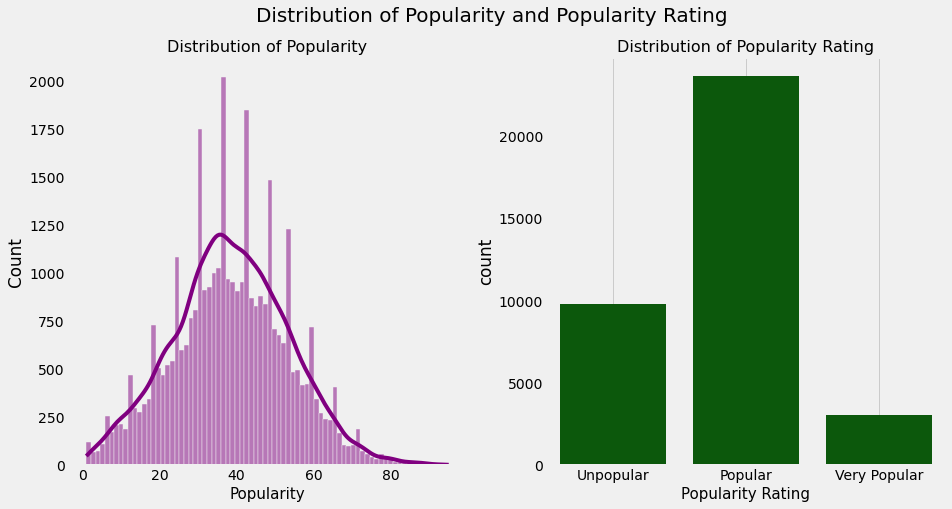

In [158]:
df['pop_rating'] = pd.Categorical(df.pop_rating, pop_ratings)

plt.rcParams['figure.figsize'] = small_figsize

plt.subplot(1, 2, 1)
sns.histplot(x=df.popularity, color = 'purple', kde=True)
plt.xlabel('Popularity', fontsize = 15)
plt.title("Distribution of Popularity", fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
sns.countplot(x=df.pop_rating, color = 'darkgreen')
plt.xlabel('Popularity Rating', fontsize = 15)
plt.title("Distribution of Popularity Rating", fontsize=16)
plt.grid()

plt.suptitle("Distribution of Popularity and Popularity Rating", fontsize=20)
plt.show()


The popularity columns looks pretty much like a normal distribution.

### Descriptive Statistics

In [159]:
print("Average Ratio of Acousticness in the Dataset: {0:.2f}".format(df['acousticness'].mean()))
print("Average Ratio of Danceability in the Dataset: {0:.2f}".format(df['danceability'].mean()))
minutes = int((df['duration_ms'].mean()//1000)//60)
seconds = int((df['duration_ms'].mean()//1000)%60)
print("Average Duration of Songs:", minutes, "minutes and", seconds, "seconds")
print("Average Ratio of Energy in the Dataset: {0:.2f}".format(df['energy'].mean()))
print("Average Ratio of Instrumentalness in the Dataset: {0:.2f}".format(df['instrumentalness'].mean()))
print("Average Ratio of Liveness in the Dataset: {0:.2f}".format(df['liveness'].mean()))
print("Average Ratio of Loudness in the Dataset: {0:.2f}".format(df['loudness'].mean()))
print("Average Ratio of Speechiness in the Dataset: {0:.2f}".format(df['speechiness'].mean()))
print("Average Tempo in the Dataset: {0:.2f}".format(df['tempo'].mean()), "bpm")
print("Average Ratio of Valence in the Dataset: {0:.2f}".format(df['valence'].mean()))
print("Average Popularity in the Dataset: {0:.2f}".format(df['popularity'].mean()))

Average Ratio of Acousticness in the Dataset: 0.29
Average Ratio of Danceability in the Dataset: 0.60
Average Duration of Songs: 3 minutes and 53 seconds
Average Ratio of Energy in the Dataset: 0.62
Average Ratio of Instrumentalness in the Dataset: 0.18
Average Ratio of Liveness in the Dataset: 0.18
Average Ratio of Loudness in the Dataset: -8.42
Average Ratio of Speechiness in the Dataset: 0.10
Average Tempo in the Dataset: 120.22 bpm
Average Ratio of Valence in the Dataset: 0.46
Average Popularity in the Dataset: 38.55


### Univariate Analysis

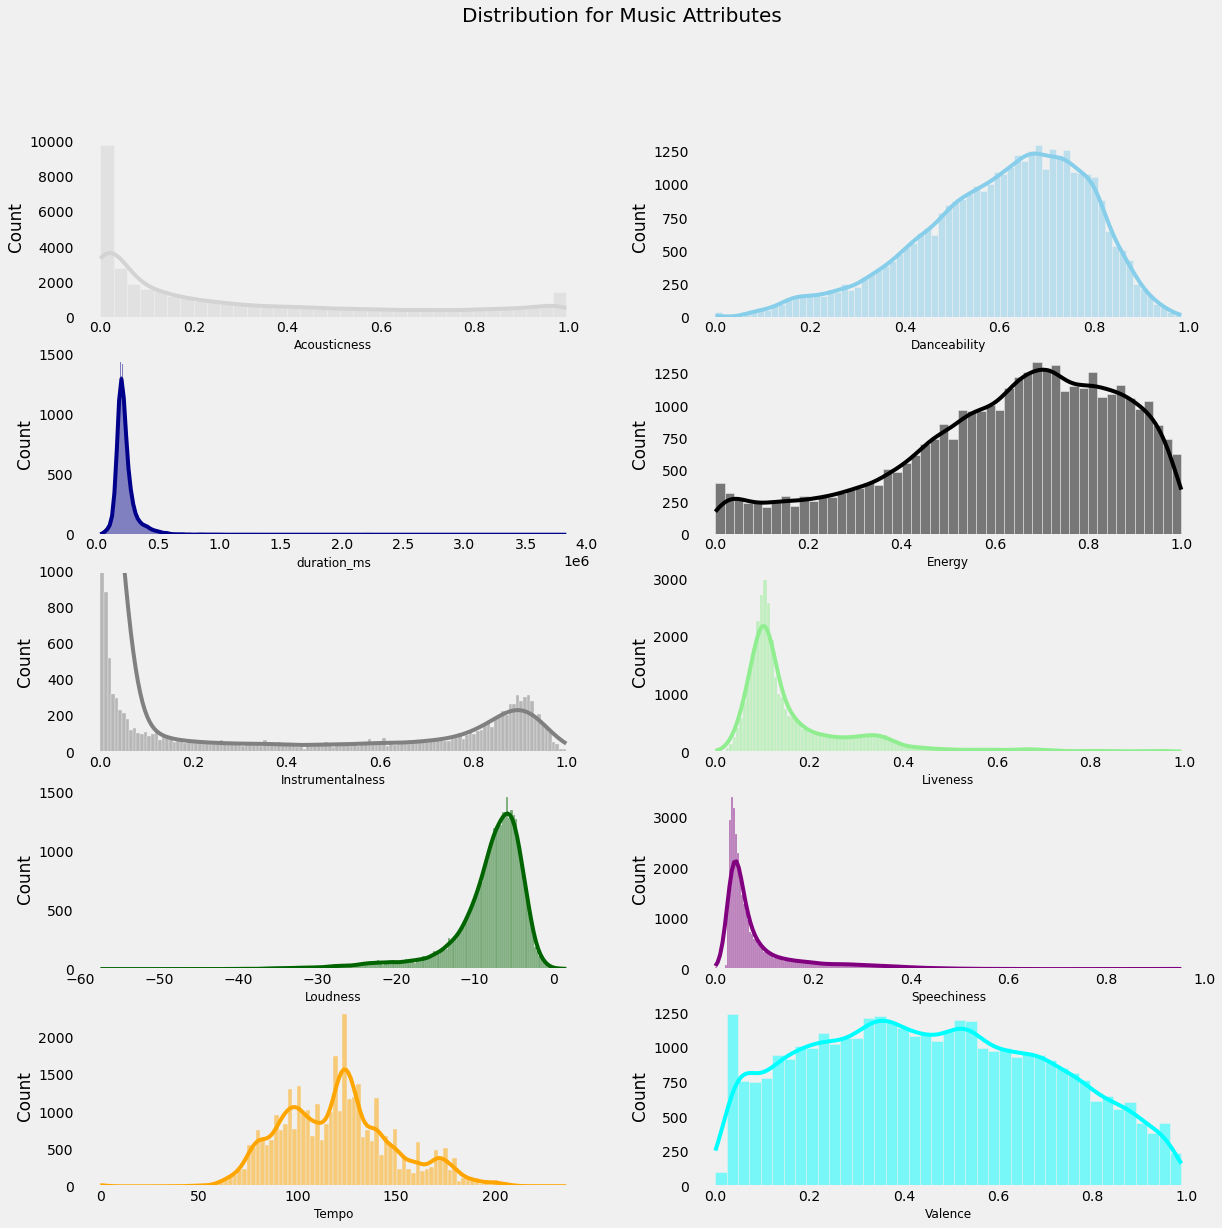

In [160]:
# check distribution of different categories in the dataset

plt.rcParams['figure.figsize'] = large_figsize

plt.subplot(5, 2, 1)
sns.histplot(df['acousticness'], color = 'lightgrey', kde=True)
plt.xlabel('Acousticness', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 2)
sns.histplot(df['danceability'], color = 'skyblue', kde=True)
plt.xlabel('Danceability', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 3)
sns.histplot(df['duration_ms'], color ='darkblue', kde=True)
plt.xlabel('duration_ms', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 4)
sns.histplot(df['energy'], color = 'black', kde=True)
plt.xlabel('Energy', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 5)
sns.histplot(df['instrumentalness'], color = 'grey', kde=True)
plt.xlabel('Instrumentalness', fontsize = 12)
plt.ylim(0, 1000)
plt.grid()

plt.subplot(5, 2, 6)
sns.histplot(df['liveness'], color = 'lightgreen', kde=True)
plt.xlabel('Liveness', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 7)
sns.histplot(df['loudness'], color = 'darkgreen', kde=True)
plt.xlabel('Loudness', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 8)
sns.histplot(df['speechiness'], color = 'purple', kde=True)
plt.xlabel('Speechiness', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 9)
sns.histplot(df['tempo'], color = 'orange', kde=True)
plt.xlabel('Tempo', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 10)
sns.histplot(df['valence'], color = 'cyan', kde=True)
plt.xlabel('Valence', fontsize = 12)
plt.grid()

plt.suptitle('Distribution for Music Attributes', fontsize = 20)
plt.show()

## Bivariate Analysis

When checking for correlation, a heatmap is useful:

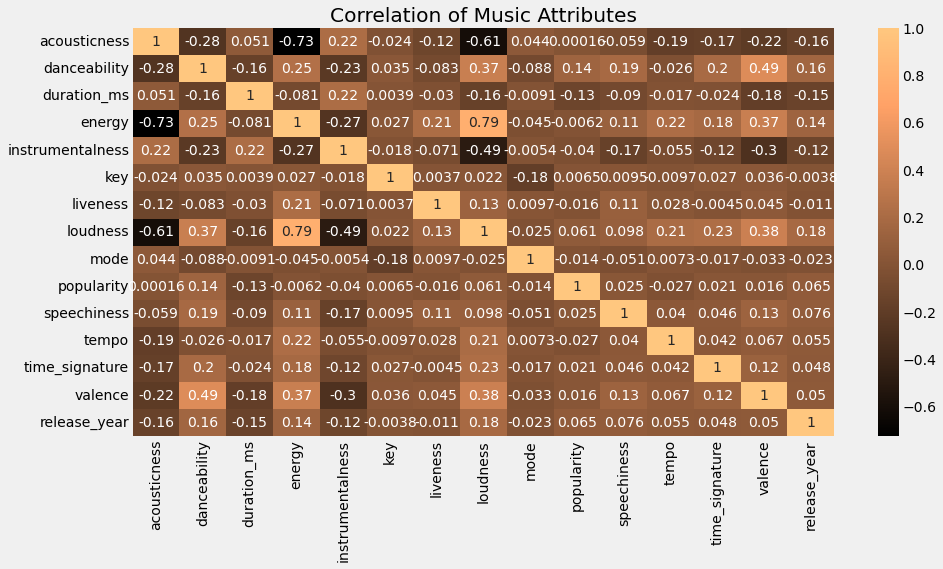

In [161]:
plt.rcParams['figure.figsize'] = small_figsize
sns.heatmap(df.corr(), annot=True, cmap='copper')
plt.title("Correlation of Music Attributes")
plt.show()

No attribute strongly relates to Popularity.

In [162]:
# Define a function to help plot a scatterplot using given inputs 
def scat_plot(x, y, hue=None, xlabel='', ylabel='', title=''):
    '''Plots a scatterplot using given inputs'''
    fig, ax = plt.subplots(figsize=(12, 6))
    _ = sns.scatterplot(x=x, y=y, hue=hue, s=14)
    _ = plt.xlabel(xlabel, fontsize=14)
    _ = plt.ylabel(ylabel, fontsize=14)
    _ = plt.title(title, fontsize=20)
    _ = plt.legend(fontsize=14)
    plt.show()
    
# Define a function to help plot a scatterplot with a regression line using given inputs 
def regress_plot(x='', y='', data=None, xlabel='', ylabel='', title=''):
    '''Plots a scatterplot with a regression line
    using given inputs'''
    fig, ax = plt.subplots(figsize=(12, 6))
    _ = sns.regplot(x=x, y=y, data=data, scatter_kws={"s": 10}, line_kws={'color':'r'})
    _ = plt.xlabel(xlabel, fontsize=14)
    _ = plt.ylabel(ylabel, fontsize=14)
    _ = plt.title(title, fontsize=20)
    _ = plt.ylim(-3, 103)
    plt.show()

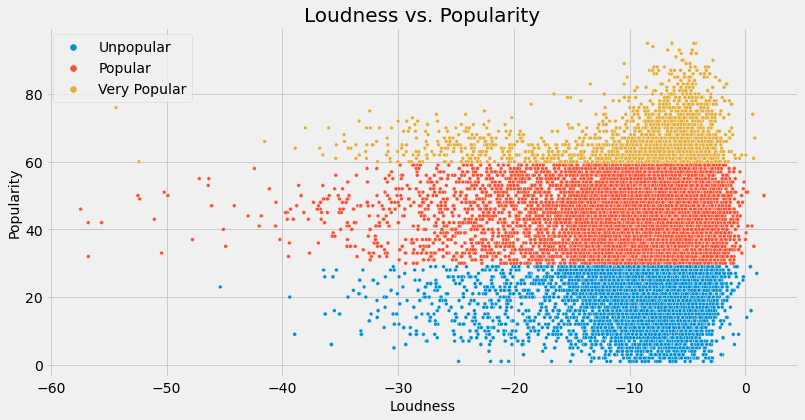

In [163]:
scat_plot(df.loudness, df.popularity, hue=df.pop_rating, ylabel="Popularity",
         xlabel="Loudness", title="Loudness vs. Popularity")

This scatterplot is more dense toward higher levels of loudness. Loudness may not guarantee popularity, but it seems the odds are greater for loud songs than songs that have low levels of loudness.

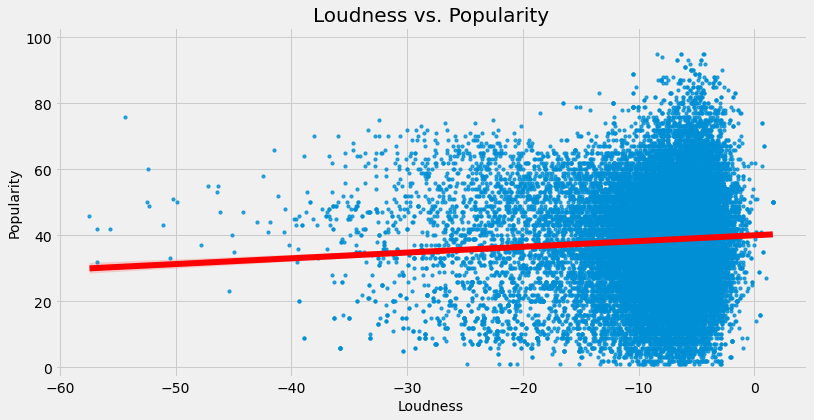

In [164]:
regress_plot(df.loudness, df.popularity, data=df, ylabel="Popularity",
         xlabel="Loudness", title="Loudness vs. Popularity")

The regressor shows there is somewhat of a positive correlation, but it's not a very strong fit.

According to the heatmap, Popularity is stronger correlated to Energy than Loudness, so let's check what that is about:

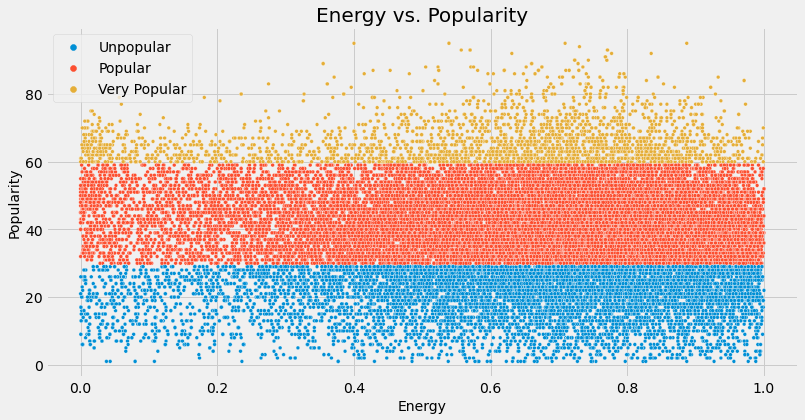

In [165]:
scat_plot(df.energy, df.popularity, hue=df.pop_rating,
          xlabel="Energy",
          ylabel="Popularity", 
          title="Energy vs. Popularity")

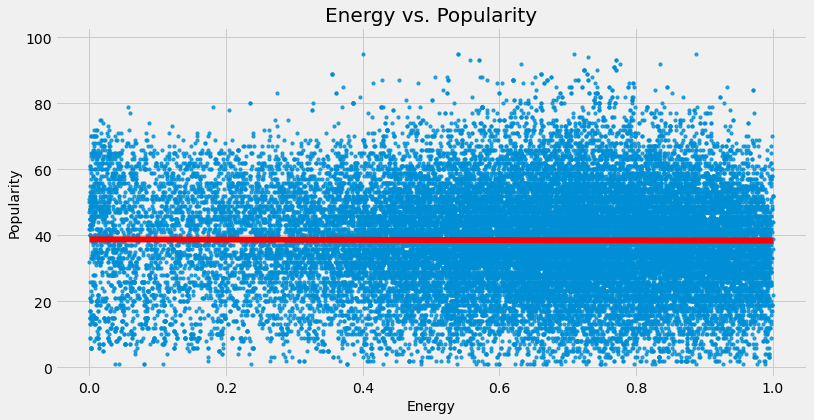

In [166]:
regress_plot(df.energy, df.popularity, data=df,
          xlabel="Energy",
          ylabel="Popularity", 
          title="Energy vs. Popularity")

Even though the regressor trends downwards, it seems that the most popular songs are high energy.

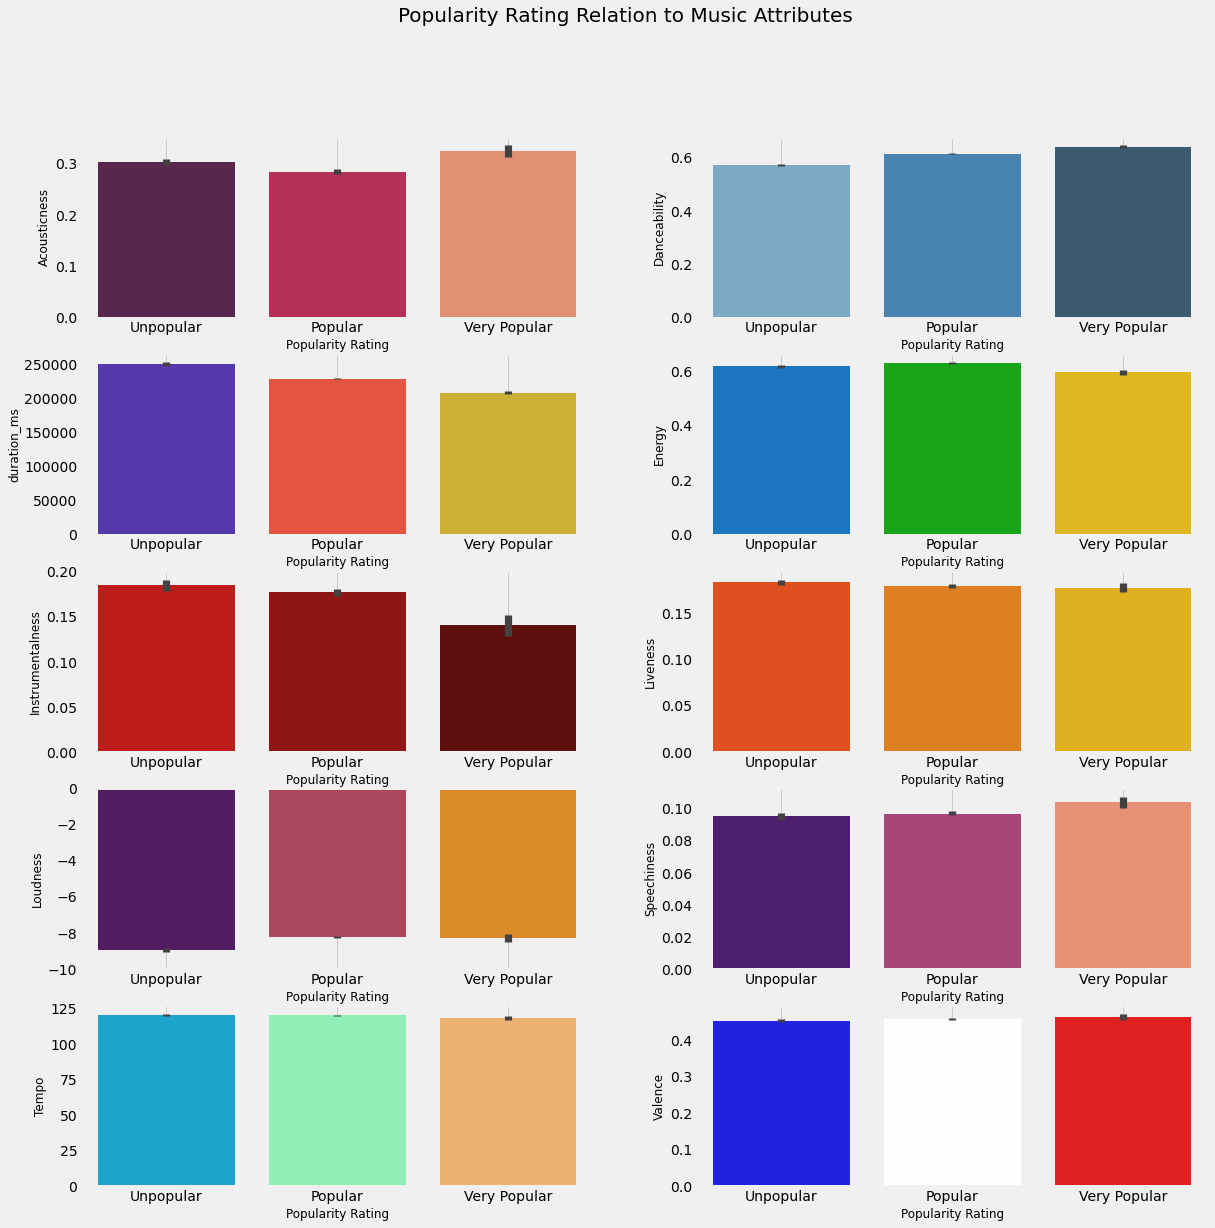

In [167]:
# Categorical vs. Numerical
plt.rcParams['figure.figsize'] = large_figsize

plt.subplot(5, 2, 1)
sns.barplot(x=df.pop_rating, y=df.acousticness, palette = 'rocket')
plt.xlabel('Popularity Rating', fontsize = 12)
plt.ylabel('Acousticness', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 2)
sns.barplot(x=df.pop_rating, y=df['danceability'], palette='Blues_d')
plt.xlabel('Popularity Rating', fontsize=12)
plt.ylabel('Danceability', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 3)
sns.barplot(x=df.pop_rating, y=df['duration_ms'], palette='CMRmap')
plt.xlabel("Popularity Rating", fontsize=12)
plt.ylabel('duration_ms', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 4)
sns.barplot(x=df.pop_rating, y=df['energy'], palette='nipy_spectral')
plt.xlabel("Popularity Rating", fontsize=12)
plt.ylabel('Energy', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 5)
sns.barplot(x=df.pop_rating, y=df['instrumentalness'], palette='flag')
plt.xlabel("Popularity Rating", fontsize=12)
plt.ylabel('Instrumentalness', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 6)
sns.barplot(x=df.pop_rating, y=df['liveness'], palette='autumn')
plt.xlabel("Popularity Rating", fontsize=12)
plt.xlabel("Popularity Rating", fontsize=12)
plt.ylabel('Liveness', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 7)
sns.barplot(x=df.pop_rating, y=df['loudness'], palette='inferno')
plt.xlabel("Popularity Rating", fontsize=12)
plt.ylabel('Loudness', fontsize = 12)
plt.ylim(-10, 0)
plt.grid()

plt.subplot(5, 2, 8)
sns.barplot(x=df.pop_rating, y=df['speechiness'], palette='magma')
plt.xlabel("Popularity Rating", fontsize=12)
plt.ylabel('Speechiness', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 9)
sns.barplot(x=df.pop_rating, y=df['tempo'], palette='rainbow')
plt.xlabel("Popularity Rating", fontsize=12)
plt.ylabel('Tempo', fontsize = 12)
plt.grid()

plt.subplot(5, 2, 10)
sns.barplot(x=df.pop_rating, y=df['valence'], palette='seismic')
plt.xlabel("Popularity Rating", fontsize=12)
plt.ylabel('Valence', fontsize = 12)
plt.grid()

plt.suptitle('Popularity Rating Relation to Music Attributes', fontsize = 20)
plt.show()

!!To be filled out!!

## Data Preprocessing

First, we're going to try without the categorical pop_rating column

In [168]:
df_cont = df.copy().reset_index(drop=True)
df_cont.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,release_year,pop_rating
0,0.1010,0.748,237667.0,0.666,0.000653,6.0,0.0976,-6.094,0.0,47.0,0.0833,114.982,4.0,0.359,2018,Popular
1,0.1910,0.608,243667.0,0.664,0.042700,5.0,0.1200,-8.261,0.0,35.0,0.0435,100.011,4.0,0.513,2018,Popular
2,0.0786,0.470,157500.0,0.828,0.000000,9.0,0.1780,-6.280,1.0,55.0,0.0700,96.149,4.0,0.856,2018,Popular
3,0.3160,0.336,207354.0,0.861,0.000107,11.0,0.2160,-3.274,1.0,41.0,0.1020,179.142,4.0,0.789,2019,Popular
4,0.1480,0.790,174189.0,0.722,0.000000,1.0,0.1720,-4.149,0.0,49.0,0.0678,98.109,4.0,0.948,2018,Popular


In [169]:
# Drop release year as we don't want it to be a factor in the prediction
index = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
         'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 
         'time_signature', 'valence', 'popularity']
df_cont.drop('pop_rating', inplace=True, axis=1)
df_cont = df_cont.reindex(columns=index)
df_cont.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,0.1010,0.748,237667.0,0.666,0.000653,6.0,0.0976,-6.094,0.0,0.0833,114.982,4.0,0.359,47.0
1,0.1910,0.608,243667.0,0.664,0.042700,5.0,0.1200,-8.261,0.0,0.0435,100.011,4.0,0.513,35.0
2,0.0786,0.470,157500.0,0.828,0.000000,9.0,0.1780,-6.280,1.0,0.0700,96.149,4.0,0.856,55.0


In [170]:
x = pd.get_dummies(df_cont['mode'])


In [171]:
df_cont = pd.concat([df_cont, x], axis=1)
df_cont.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,0.0,1.0
0,0.1010,0.748,237667.0,0.666,0.000653,6.0,0.0976,-6.094,0.0,0.0833,114.982,4.0,0.359,47.0,1,0
1,0.1910,0.608,243667.0,0.664,0.042700,5.0,0.1200,-8.261,0.0,0.0435,100.011,4.0,0.513,35.0,1,0
2,0.0786,0.470,157500.0,0.828,0.000000,9.0,0.1780,-6.280,1.0,0.0700,96.149,4.0,0.856,55.0,0,1


In [172]:
df_cont.rename(columns = {0.0: 'major key', 1.0: 'minor key'}, inplace=True)
df_cont.drop('mode', inplace=True, axis=1)


In [173]:
index = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
         'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 
         'time_signature', 'valence', 'major key', 
         'minor key','popularity']
df_cont = df_cont.reindex(columns=index)
df_cont.drop('mode', inplace=True, axis=1)
df_cont.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,major key,minor key,popularity
0,0.1010,0.748,237667.0,0.666,0.000653,6.0,0.0976,-6.094,0.0833,114.982,4.0,0.359,1,0,47.0
1,0.1910,0.608,243667.0,0.664,0.042700,5.0,0.1200,-8.261,0.0435,100.011,4.0,0.513,1,0,35.0
2,0.0786,0.470,157500.0,0.828,0.000000,9.0,0.1780,-6.280,0.0700,96.149,4.0,0.856,0,1,55.0


### Splitting the Data

In [174]:
Y = df_cont['popularity']
X = df_cont.iloc[:, 0:-1]
print("The shape of X:", X.shape)
print("The shape of Y:", Y.shape)

The shape of X: (36435, 14)
The shape of Y: (36435,)


In [175]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("The shape of x_train:", x_train.shape)
print("The shape of x_test:", x_test.shape)
print("The shape of y_train:", y_train.shape)
print("The shape of y_test:", y_test.shape)

The shape of x_train: (29148, 14)
The shape of x_test: (7287, 14)
The shape of y_train: (29148,)
The shape of y_test: (7287,)


*change* Now that the data has been split with train_test_split, we can fit the training data and calculate the R2 score. This process, and all the similar ones to follow, is timed to get an understanding of the computational requirements for each model.

In addition to the standard R2 score, I also created a custom loss function to give a more concrete perspective on the model performance. This function, custom_loss, calculates counts for different levels of error between the predicted values and the actual test values, and also gives an overall average of the differences between predicted and actual.

In [176]:
# This function only works with the continuous models, not with classifiers
def loss_function(predicts, truths):
    zipped = zip(predicts, truths)
    zipped_list = list(zipped)
    differences = {'Less than 5': 0, '5 - 10': 0, 'More than 10': 0, 'Average Error': 0}
    sum = 0

    for pair in zipped_list:
        sum += abs(pair[0] - pair[1])
        if abs(pair[0] - pair[1]) < 5:
            differences['Less than 5'] += 1
        elif 5 <= abs(pair[0] - pair[1]) < 10:
            differences['5 - 10'] += 1
        else:
            differences['More than 10'] += 1
            
    differences['Average Error'] = sum / len(zipped_list)
     
    return differences

*change* With the custom loss function set and the data split, we can begin running the models.

In [177]:
%%time

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

print(lr.score(x_test, y_test))

0.04190065431881562
CPU times: user 36.2 ms, sys: 5.13 ms, total: 41.4 ms
Wall time: 17.2 ms


In [178]:
loss_function(y_pred, y_test)

{'Less than 5': 1987,
 '5 - 10': 1749,
 'More than 10': 3551,
 'Average Error': 11.672639816814572}

** CHANGE** The score for the model above is not very good. On the other hand, the custom metric isn't as bad as the score would lead one to believe. There may be over 16,000 predictions well off the mark, but a good many were reasonably accurate, and the average difference isn't terrible.

To take it a step further, let's see what happens when using the categoricals by using one hot encoding with .get_dummies(). For this step, I decided to drop the artist_name column. While song popularity is often correlated with artist popularity, the hope is for this model to work just as well on an artist it hasn't seen before. Part of the goal is to be able to discover new talent, and that becomes more difficult if the algorithm is inclined to discredit a song just because it doesn't recognize the artist. Therefore, the column is dropped for training purposes. This new dataset is stored as df_encoded.

## Preprocessing

In [179]:
df_cat = df.copy().reset_index()
df_cat.drop(['index', 'popularity', 'release_year'], inplace=True, axis=1)
df_cat.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,pop_rating
0,0.1010,0.748,237667.0,0.666,0.000653,6.0,0.0976,-6.094,0.0,0.0833,114.982,4.0,0.359,Popular
1,0.1910,0.608,243667.0,0.664,0.042700,5.0,0.1200,-8.261,0.0,0.0435,100.011,4.0,0.513,Popular
2,0.0786,0.470,157500.0,0.828,0.000000,9.0,0.1780,-6.280,1.0,0.0700,96.149,4.0,0.856,Popular


In [180]:
# Replace Ordinal Values
df_cat['pop_rating'] = df_cat['pop_rating'].replace(('Very Popular', 'Popular', 'Unpopular'), (3, 2, 1))
df_cat['pop_rating'].value_counts()

2    23612
1     9796
3     3027
Name: pop_rating, dtype: int64

### Splitting and Normalizing the data

All attribute columns range between 0 and 1, except for duration_ms, loudness, tempo, and release_year. Let's normalize them.

In [181]:
YY = df_cat['pop_rating']
XX = df_cat.drop('pop_rating', axis=1)

print(XX.shape)
print(YY.shape)

(36435, 13)
(36435,)


In [182]:
XX.head(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.1010,0.748,237667.0,0.666,0.000653,6.0,0.0976,-6.094,0.0,0.0833,114.982,4.0,0.359
1,0.1910,0.608,243667.0,0.664,0.042700,5.0,0.1200,-8.261,0.0,0.0435,100.011,4.0,0.513
2,0.0786,0.470,157500.0,0.828,0.000000,9.0,0.1780,-6.280,1.0,0.0700,96.149,4.0,0.856


In [183]:
YY.head()

0    2
1    2
2    2
3    2
4    2
Name: pop_rating, dtype: int64

The target data is imbalanced, so we'll implement SMOTE.

In [184]:
from imblearn.over_sampling import SMOTE

sn = SMOTE(random_state=0)

sn.fit(XX, YY)

x_resampled, y_resampled = sn.fit_resample(XX, YY)

print(x_resampled.shape)
print(y_resampled.shape)

(70836, 13)
(70836,)


In [185]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=0)

print("The shape of x_train:", x_train.shape)
print("The shape of x_test:", x_test.shape)
print("The shape of y_train:", y_train.shape)
print("The shape of y_test:", y_test.shape)
print()
print(y_train.value_counts())
print()
print(y_test.value_counts())

The shape of x_train: (53127, 13)
The shape of x_test: (17709, 13)
The shape of y_train: (53127,)
The shape of y_test: (17709,)

1    17784
2    17744
3    17599
Name: pop_rating, dtype: int64

3    6013
2    5868
1    5828
Name: pop_rating, dtype: int64


In [186]:
x_test.isna().sum()


acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [187]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

print(lr.score(x_test, y_test))

0.06349706683612155


In [188]:
cvals = cross_val_score(lr, XX, YY, cv=6)

# check the results
print(cvals)
print('The mean cross-validation score is: {num:.{dig}f}'.format\
      (num=np.mean(cvals), dig=4))

[-0.05056903 -0.05893093  0.01538057  0.02197774 -0.01798018 -0.12905763]
The mean cross-validation score is: -0.0365


## Build Classification Model

In [189]:
# Basic decision tree
model1 = DecisionTreeClassifier(max_depth=20, random_state=25)
model1.fit(x_train, y_train)

y_pred = model1.predict(x_test)

print(accuracy_score(y_test, y_pred))

0.6878988085154442


In [190]:
params = {'max_depth': [2, 10, 20, 40, 50],
         'min_samples_leaf': np.arange(1, 10, 2),}

model1 = DecisionTreeClassifier(random_state=0)

model1_cv = GridSearchCV(model1, params, cv=6)

model1_cv.fit(x_train, y_train)

print(model1_cv.best_params_)
print('The average runtime is: ', np.mean(model1_cv.cv_results_['mean_fit_time']))
print('The best score is: ', model1_cv.best_score_)

{'max_depth': 40, 'min_samples_leaf': 1}
The average runtime is:  0.45436090151468916
The best score is:  0.6813108149089921


In [191]:
p = model1_cv.best_estimator_.predict(x_test)

print(accuracy_score(y_test, p))

0.7017335817945677


### Bagging


[0.45420666 0.44054207 0.44415584 0.4494014  0.45132144 0.45053083]
The mean cross-validation score is: 0.4484


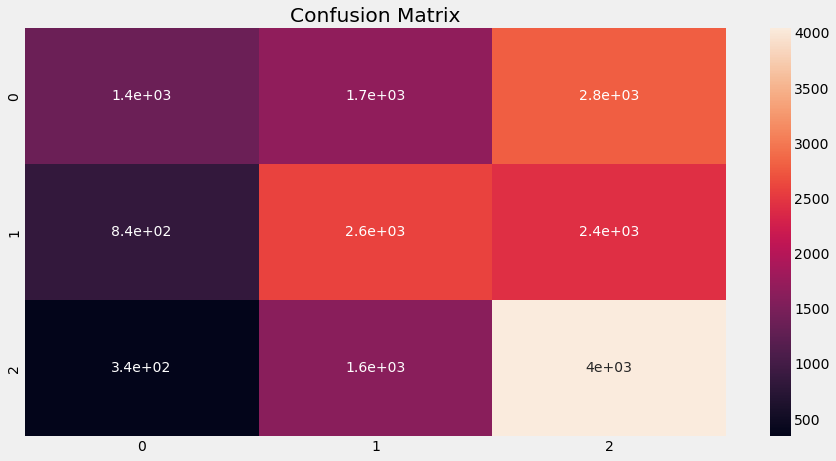

CPU times: user 42.1 s, sys: 480 ms, total: 42.5 s
Wall time: 44 s


In [192]:
%%time

from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
model2 = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=0)

bag_cv = cross_val_score(model2, x_train, y_train, cv=6)
model2.fit(x_train, y_train)
y_pred = model2.predict(x_test)

print(bag_cv)
print('The mean cross-validation score is: {num:.{dig}f}'.format\
      (num=np.mean(bag_cv), dig=4))
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = small_figsize
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.show()

In [193]:
# Accuracy and Classification Report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.45123948274888476
              precision    recall  f1-score   support

           1       0.53      0.23      0.32      5828
           2       0.44      0.44      0.44      5868
           3       0.44      0.67      0.53      6013

    accuracy                           0.45     17709
   macro avg       0.47      0.45      0.43     17709
weighted avg       0.47      0.45      0.43     17709



### Random Forest

In [194]:
%%time

model3 = RandomForestClassifier(n_estimators=100, random_state=25)
model3.fit(x_train, y_train)

y_pred = model3.predict(x_test)

print(accuracy_score(y_pred, y_test))

0.8001581116946186
CPU times: user 12.9 s, sys: 162 ms, total: 13.1 s
Wall time: 13.2 s


In [195]:
model3_params = {'n_estimators': [100, 300, 350],
            'max_depth': [2, 5, 100],
            'min_samples_leaf': [1, 2]}

model3_new = RandomForestClassifier(random_state=25)

model3_cv = GridSearchCV(model3_new, model3_params, n_jobs=-1, cv=6)

model3_cv.fit(x_train, y_train)

print(model3_cv.best_params_)

{'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 350}


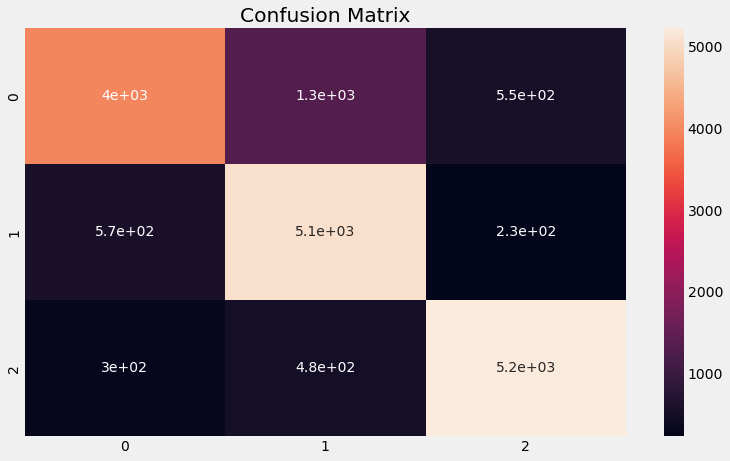

CPU times: user 45.5 s, sys: 704 ms, total: 46.2 s
Wall time: 46.9 s


In [196]:
%%time

model3 = RandomForestClassifier(max_depth=100, n_estimators=350, min_samples_leaf=1, random_state=25)

model3.fit(x_train, y_train)

y_pred = model3.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (12, 7)
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.show()

In [197]:
# Accuracy and Classification Report
print(accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
# print()
# loss_function(y_pred, y_test)

0.8055226156191767

              precision    recall  f1-score   support

           1       0.82      0.68      0.74      5828
           2       0.74      0.86      0.80      5868
           3       0.87      0.87      0.87      6013

    accuracy                           0.81     17709
   macro avg       0.81      0.80      0.80     17709
weighted avg       0.81      0.81      0.80     17709



The confusion matrix and classification report look very promising!

### Boosting Models


I want to explore if the model improves when using AdaBoost and Gradient Boosting.

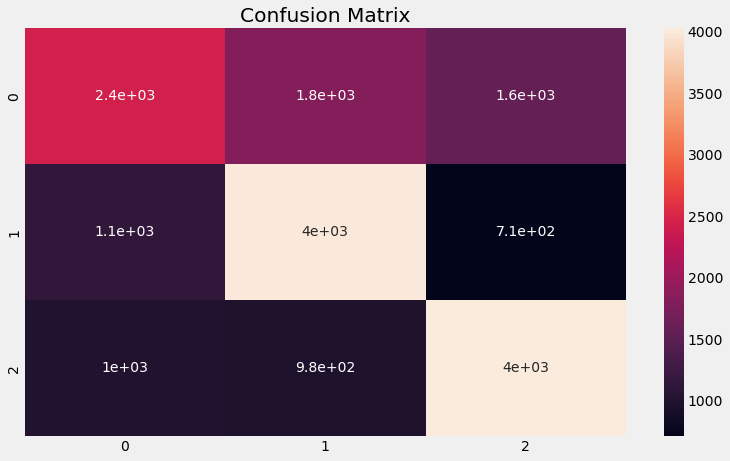

CPU times: user 12.6 s, sys: 138 ms, total: 12.8 s
Wall time: 13 s


In [198]:
%%time

dtc = DecisionTreeClassifier(max_depth=1, random_state=25)

model4 = AdaBoostClassifier(base_estimator=dtc, n_estimators=200)

model4.fit(x_train, y_train)

y_pred = model4.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (12, 7)
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.show()

In [199]:
# Accuracy and Classification Report
print(accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

0.592015359421763

              precision    recall  f1-score   support

           1       0.53      0.42      0.47      5828
           2       0.59      0.68      0.63      5868
           3       0.64      0.67      0.65      6013

    accuracy                           0.59     17709
   macro avg       0.59      0.59      0.59     17709
weighted avg       0.59      0.59      0.59     17709



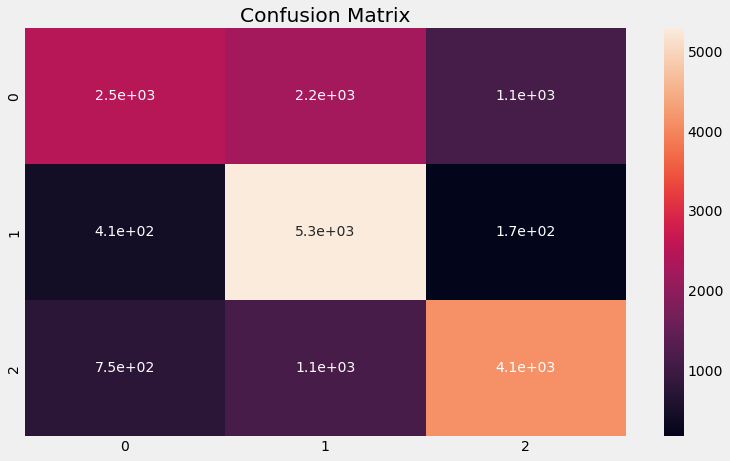

CPU times: user 1min 27s, sys: 1.59 s, total: 1min 28s
Wall time: 1min 30s


In [200]:
%%time

model5 = GradientBoostingClassifier(max_depth=3, n_estimators=200, random_state=0)

model5.fit(x_train, y_train)

y_pred = model5.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (12, 7)
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.show()

In [201]:
# Accuracy and Classification Report
print(accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

0.6712970805804958

              precision    recall  f1-score   support

           1       0.68      0.42      0.52      5828
           2       0.61      0.90      0.73      5868
           3       0.76      0.69      0.72      6013

    accuracy                           0.67     17709
   macro avg       0.68      0.67      0.66     17709
weighted avg       0.69      0.67      0.66     17709



For this dataset the Random Forest Model seems to wok best. So we'll be going with that one.

In [202]:
# Save the Random Forest model in a pickle file
filepath = 'music_pop_predictor.pkl'
with open(filepath, 'wb') as f:
    pickle.dump(model3, f)
'''with gzip.open(filepath, 'wb') as f:
    pickled = pickle.dumps(model3)
    optimized_pickle = pickletools.optimize(pickled)
    f.write(optimized_pickle)'''


"with gzip.open(filepath, 'wb') as f:\n    pickled = pickle.dumps(model3)\n    optimized_pickle = pickletools.optimize(pickled)\n    f.write(optimized_pickle)"

In [203]:
'''# to deserialize/load back:
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    model = p.load()'''

"# to deserialize/load back:\nwith gzip.open(filepath, 'rb') as f:\n    p = pickle.Unpickler(f)\n    model = p.load()"

In [204]:
col_list = x_test.columns.tolist()
col_list

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence']

In [205]:
filepath = 'music_pop_predictor.pkl'
with open(filepath, 'rb') as f:
    model = pickle.load(f)

y_pred = model.predict(x_test)